### Using Phantom Buster data collection. The table is different from the steviesie parsing output.
    12 Aug:
    1. Have setup 4 phantoms. Till 11th, collected #organic,#sustainable,#fairtrade. 
    2. From 12th, individual phantoms being executed to estimate weekly data volumes. Basis this, can device a monthly or yearly data collection plan. 

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import unicodedata
from langdetect import detect

from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

import os

In [2]:
pd.set_option('display.max_columns', None) #display all columns.pass none to the max_col parameter
pd.set_option('display.max_colwidth', None) #for indivdual cell full display

organic=pd.read_csv('Organic_6_aug.csv')
organic.head()

,query,timestamp,error,postUrl,profileUrl,username,fullName,commentCount,likeCount,pubDate,description,imgUrl,postId,ownerId,type,videoUrl,viewCount
0,#organic,2021-08-06T08:34:30.222Z,No results found,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,#organic,2021-08-06T08:37:08.488Z,No results found,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#organic,2021-08-06T09:44:31.069Z,NaN,https://www.instagram.com/p/CSOnatvnYsU/,https://www.instagram.com/foodout21,foodout21,Som Singh,0.0,0.0,2021-08-06T09:44:22.000Z,#l4l #f4f #likeforlike #instalikesandfollowers4u #nature #instagood #organic #fff #love #vegandiet #nutricious #followforfollow #photooftheday #lfl #like4like #instalike #vegetables #instafood #healthyfood #follow4follow #food #instadaily @rocket_hastags #healthy #foodpics #veganlife,https://scontent-lhr8-1.cdninstagram.com/v/t51.2885-15/e35/233679786_3987731464668891_529215599653319727_n.jpg?_nc_ht=scontent-lhr8-1.cdninstagram.com&_nc_cat=103&_nc_ohc=tgQJNprk4HwAX-bXXR9&edm=ABZsPhsBAAAA&ccb=7-4&oh=54d10aa13a15440590967464b19e3c29&oe=611315D8&_nc_sid=4efc9f&ig_cache_key=MjYzNDIxNjE5MTY5NTg4MzAyOA%3D%3D.2-ccb7-4,2.634216e+18,4.868702e+10,Photo,NaN,NaN
3,#organic,2021-08-06T09:44:31.069Z,NaN,https://www.instagram.com/p/CSOnanrLQli/,https://www.instagram.com/carboncoco.cz,carboncoco.cz,CarbonCoco Česká Republika,0.0,0.0,2021-08-06T09:44:21.000Z,Originál je pouze jeden! Posílame každý den kurýrem přímo k vám..📬 Děkujeme za krásné foto..❤️ https://carboncoco.cz/ ⚫️👉🏽😁👉🏽💎 @carboncoco_cz #přírodní #bělení #zubů #krásnej #zdravej #bílej #úsměv #bezbolesti #bezchemie #naturalbeauty #organic #whiteteeth #veganfriendly #nottestedonanimals #🐾❤,https://scontent-lhr8-1.cdninstagram.com/v/t51.2885-15/e35/232412268_526973671848863_6524457970286802515_n.jpg?_nc_ht=scontent-lhr8-1.cdninstagram.com&_nc_cat=111&_nc_ohc=9vQrTLY4G_UAX-WvRgT&edm=ABZsPhsBAAAA&ccb=7-4&oh=aa1ac9df30470cbbcf7bdbc7c95acb4a&oe=6113E033&_nc_sid=4efc9f&ig_cache_key=MjYzNDIxNjE4NTE3ODk0OTk4Ng%3D%3D.2-ccb7-4,2.634216e+18,6.939315e+09,Photo,NaN,NaN
4,#organic,2021-08-06T09:44:31.069Z,NaN,https://www.instagram.com/p/CSOnZ0bD9n7/,https://www.instagram.com/sourdoughlybread,sourdoughlybread,Sourdoughly,0.0,0.0,2021-08-06T09:44:15.000Z,R&amp;D\n.\n.\n.\n.\n.\n.\n.\n.\n\n#organic #organicbread #homebaker #homebakery #realbread #properbread #artisanbread #naturallyleaven #leavenbread #sourdough #sourdoughlybread #breaddiaries #bread #homebaking #homemadebread #breadmaking #peckham #foresthill,https://scontent-lhr8-2.cdninstagram.com/v/t51.2885-15/e35/233671587_247345317223226_1436442095672934247_n.jpg?_nc_ht=scontent-lhr8-2.cdninstagram.com&_nc_cat=102&_nc_ohc=EG_NhMpmUj4AX9T8ctJ&edm=ABZsPhsBAAAA&ccb=7-4&oh=7af45d0c391a1fa96c6cdc29d67a2950&oe=611373D6&_nc_sid=4efc9f&ig_cache_key=MjYzNDIxNjEzMDE0Nzc2ODgyNw%3D%3D.2-ccb7-4,2.634216e+18,6.662659e+09,Photo,NaN,NaN


In [3]:
organic=pd.read_csv('Organic_6_aug.csv')
organic.drop(list(range(0,2)),inplace=True) #Drop first 2 entries since Nan failed attempts
#organic.head(2)

In [4]:
# Define functions for creating new columns from the description column

## To apply on individual columns. 
# def clean_caption(row):
#         X = str(row['description']).split()
#         X_new = [x for x in X if not x.startswith(('#','@'))]
#         return ' '.join(X_new)
             
# def hashtags(row):
#         X = str(row['description']).split()
#         X_new = [x for x in X if x.startswith("#")]
#         return ' '.join(X_new)

# def cap_mentions(row):
#         X = str(row['description']).split()
#         X_new = [x for x in X if x.startswith("@")]
#         return ' '.join(X_new)
    
    
    
#Wrap all functions into a single function to apply on entire dataframe   
def caption_columns(df):
    df_upd=df
    df_upd['clean_captions']=" "
    df_upd['hashtags']=" "
    df_upd['cap_mentions']=" "
    df_upd['web_links']=" "
    
    for ind,row in df_upd.iterrows():
        X=str(row['description']).split()
        X_cc=[]
        X_hstgs=[]
        X_cms=[]
        X_http=[]
        
        for x in X:            
            if not (x.startswith(('#','@','http')) or ('www.' in x) or ('.com' in x)) :
                X_cc.append(x)
                
            if x.startswith('#'):
                X_hstgs.append(x)
                
            if x.startswith('@'):
                X_cms.append(x)
                
            if (x.startswith('http') or ('www.' in x) or ('.com' in x)):
                X_http.append(x)
                
                

        df_upd.at[ind,'clean_captions'] = ' '.join(X_cc)        
        df_upd.at[ind,'hashtags'] = ' '.join(X_hstgs)
        df_upd.at[ind,'cap_mentions'] = ' '.join(X_cms)
        df_upd.at[ind,'web_links'] = ' '.join(X_http)
    
    return df_upd
            

In [5]:
pd.set_option("display.max_rows", None)
df_updated=caption_columns(organic)
df_updated.head(100)

,query,timestamp,error,postUrl,profileUrl,username,fullName,commentCount,likeCount,pubDate,description,imgUrl,postId,ownerId,type,videoUrl,viewCount,clean_captions,hashtags,cap_mentions,web_links
2,#organic,2021-08-06T09:44:31.069Z,NaN,https://www.instagram.com/p/CSOnatvnYsU/,https://www.instagram.com/foodout21,foodout21,Som Singh,0.0,0.0,2021-08-06T09:44:22.000Z,#l4l #f4f #likeforlike #instalikesandfollowers4u #nature #instagood #organic #fff #love #vegandiet #nutricious #followforfollow #photooftheday #lfl #like4like #instalike #vegetables #instafood #healthyfood #follow4follow #food #instadaily @rocket_hastags #healthy #foodpics #veganlife,https://scontent-lhr8-1.cdninstagram.com/v/t51.2885-15/e35/233679786_3987731464668891_529215599653319727_n.jpg?_nc_ht=scontent-lhr8-1.cdninstagram.com&_nc_cat=103&_nc_ohc=tgQJNprk4HwAX-bXXR9&edm=ABZsPhsBAAAA&ccb=7-4&oh=54d10aa13a15440590967464b19e3c29&oe=611315D8&_nc_sid=4efc9f&ig_cache_key=MjYzNDIxNjE5MTY5NTg4MzAyOA%3D%3D.2-ccb7-4,2.634216e+18,4.868702e+10,Photo,NaN,NaN,,#l4l #f4f #likeforlike #instalikesandfollowers4u #nature #instagood #organic #fff #love #vegandiet #nutricious #followforfollow #photooftheday #lfl #like4like #instalike #vegetables #instafood #healthyfood #follow4follow #food #instadaily #healthy #foodpics #veganlife,@rocket_hastags,
3,#organic,2021-08-06T09:44:31.069Z,NaN,https://www.instagram.com/p/CSOnanrLQli/,https://www.instagram.com/carboncoco.cz,carboncoco.cz,CarbonCoco Česká Republika,0.0,0.0,2021-08-06T09:44:21.000Z,Originál je pouze jeden! Posílame každý den kurýrem přímo k vám..📬 Děkujeme za krásné foto..❤️ https://carboncoco.cz/ ⚫️👉🏽😁👉🏽💎 @carboncoco_cz #přírodní #bělení #zubů #krásnej #zdravej #bílej #úsměv #bezbolesti #bezchemie #naturalbeauty #organic #whiteteeth #veganfriendly #nottestedonanimals #🐾❤,https://scontent-lhr8-1.cdninstagram.com/v/t51.2885-15/e35/232412268_526973671848863_6524457970286802515_n.jpg?_nc_ht=scontent-lhr8-1.cdninstagram.com&_nc_cat=111&_nc_ohc=9vQrTLY4G_UAX-WvRgT&edm=ABZsPhsBAAAA&ccb=7-4&oh=aa1ac9df30470cbbcf7bdbc7c95acb4a&oe=6113E033&_nc_sid=4efc9f&ig_cache_key=MjYzNDIxNjE4NTE3ODk0OTk4Ng%3D%3D.2-ccb7-4,2.634216e+18,6.939315e+09,Photo,NaN,NaN,Originál je pouze jeden! Posílame každý den kurýrem přímo k vám..📬 Děkujeme za krásné foto..❤️ ⚫️👉🏽😁👉🏽💎,#přírodní #bělení #zubů #krásnej #zdravej #bílej #úsměv #bezbolesti #bezchemie #naturalbeauty #organic #whiteteeth #veganfriendly #nottestedonanimals #🐾❤,@carboncoco_cz,https://carboncoco.cz/
4,#organic,2021-08-06T09:44:31.069Z,NaN,https://www.instagram.com/p/CSOnZ0bD9n7/,https://www.instagram.com/sourdoughlybread,sourdoughlybread,Sourdoughly,0.0,0.0,2021-08-06T09:44:15.000Z,R&amp;D\n.\n.\n.\n.\n.\n.\n.\n.\n\n#organic #organicbread #homebaker #homebakery #realbread #properbread #artisanbread #naturallyleaven #leavenbread #sourdough #sourdoughlybread #breaddiaries #bread #homebaking #homemadebread #breadmaking #peckham #foresthill,https://scontent-lhr8-2.cdninstagram.com/v/t51.2885-15/e35/233671587_247345317223226_1436442095672934247_n.jpg?_nc_ht=scontent-lhr8-2.cdninstagram.com&_nc_cat=102&_nc_ohc=EG_NhMpmUj4AX9T8ctJ&edm=ABZsPhsBAAAA&ccb=7-4&oh=7af45d0c391a1fa96c6cdc29d67a2950&oe=611373D6&_nc_sid=4efc9f&ig_cache_key=MjYzNDIxNjEzMDE0Nzc2ODgyNw%3D%3D.2-ccb7-4,2.634216e+18,6.662659e+09,Photo,NaN,NaN,R&amp;D . . . . . . . .,#organic #organicbread #homebaker #homebakery #realbread #properbread #artisanbread #naturallyleaven #leavenbread #sourdough #sourdoughlybread #breaddiaries #bread #homebaking #homemadebread #breadmaking #peckham #foresthill,,
5,#organic,2021-08-06T09:44:31.069Z,NaN,https://www.instagram.com/p/CSOnYvksuuB/,https://www.instagram.com/food.by.joann,food.by.joann,Jo-Ann Dijkstra,0.0,0.0,2021-08-06T09:44:06.000Z,"Udon noedels met kipfilet, Thaise groenten en rode curry. Een super lekker Aziatisch gerecht dat ook nog eens snel op tafel staat. Ik ben sinds kort gaan koken met de noodles van @hakubaku_official en ik ben super tevreden. De sm

## LDA viz

In [6]:
#organic.head()

In [7]:
#Use this template to update the columns order
cols = df_updated.columns.tolist()


df_updated=df_updated[['query',
 'timestamp',
 'error',
 'postUrl',
 'profileUrl',
 'username',
 'fullName',
 'commentCount',
 'likeCount',
 'pubDate',
 'description',
 'clean_captions',
 'hashtags',
 'cap_mentions',
 'web_links',
 'imgUrl',
 'postId',
 'ownerId',
 'type',
 'videoUrl',
 'viewCount',
 ]]
#pd.DataFrame(df_updated.iloc[6])
#df_updated.iloc[4:5]


#Cut the dataframe into desired views 
view1=['description',
 'clean_captions',
  ]


df_updated[view1].loc[[11]]

,description,clean_captions
11,Health is precious - protect it.\n\nFor more information contact:\nShatayu Ayurved - 9826092380.\n.\n.\n.\n#ayurveda #yoga #ayurvedalifestyle #health #ayurvedalife #ayurvedic #healthylifestyle #ayurvedaeveryday #ayurvedicmedicine #wellness #india #natural #meditation #vegan #ayurvedafood #organic #fitness #bhopal #khalsads,Health is precious - protect it. For more information contact: Shatayu Ayurved - 9826092380. . . .


# Alternative Processing step 1 -
    convert to lower case, remove punctuation, remove apostrophe.
    can make more specific alteration of num2words.

In [8]:
#Use these transformations instead of regex of only alphabets.Can separate for num2word as in the previous step


def font_uniformity(x):
    return unicodedata.normalize('NFKC', x)


def convert_lower_case(s):
    return np.char.lower(s)


def remove_punctuation(data):
    symbols = "!\"#$%&()*+-.•/:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
    
    data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data


def diff_encodings(s):
    s = np.char.replace(s, "…", " ")
    s = np.char.replace(s, "’", "")
    return s


#Change to reference 'clean_captions' bypass step 1
df_updated['caption_processed']=df_updated['clean_captions'].apply(lambda x: font_uniformity(x))
df_updated['caption_processed_2']=df_updated['caption_processed'].apply(lambda x: convert_lower_case(x))
df_updated['caption_processed_3']=df_updated['caption_processed_2'].apply(lambda x: remove_punctuation(x))
df_updated['caption_processed_4']=df_updated['caption_processed_3'].apply(lambda x: diff_encodings(x))


In [9]:
#Add column to viewing dataframe
view2=[]
view2=['clean_captions','caption_processed','caption_processed_2', 'caption_processed_3', 'caption_processed_4']
#view2=view1+view2




#define the rows to display-exemplars of diff test cases
ex_row_list=[11,13,23,106]

df_updated[view2].loc[ex_row_list]

#df_updated[view2].head(30)

,clean_captions,caption_processed,caption_processed_2,caption_processed_3,caption_processed_4
11,Health is precious - protect it. For more information contact: Shatayu Ayurved - 9826092380. . . .,Health is precious - protect it. For more information contact: Shatayu Ayurved - 9826092380. . . .,health is precious - protect it. for more information contact: shatayu ayurved - 9826092380. . . .,health is precious protect it for more information contact shatayu ayurved 9826092380,health is precious protect it for more information contact shatayu ayurved 9826092380
13,"Shatkratu is one of the 10 sacred flowers (Dashpushpam) in Kerala, also called ""Love in a Puff"". Enhances hair growth, thickening &amp; reduces hair fall strengthening the hair roots. . .","Shatkratu is one of the 10 sacred flowers (Dashpushpam) in Kerala, also called ""Love in a Puff"". Enhances hair growth, thickening &amp; reduces hair fall strengthening the hair roots. . .","shatkratu is one of the 10 sacred flowers (dashpushpam) in kerala, also called ""love in a puff"". enhances hair growth, thickening &amp; reduces hair fall strengthening the hair roots. . .",shatkratu is one of the 10 sacred flowers dashpushpam in kerala also called love in a puff enhances hair growth thickening amp reduces hair fall strengthening the hair roots,shatkratu is one of the 10 sacred flowers dashpushpam in kerala also called love in a puff enhances hair growth thickening amp reduces hair fall strengthening the hair roots
23,"She’s here! Judith is here! She has cucumbers, MELONS, courgettes, herbs, chard, plums, beetroot, MELONS… did I mention MELONS!? I’m very excited about this little collab. She’s a star and I can’t wait to see what she brings to She’s already sold a big bag full to a regular so you’d better get down here quickly!","She’s here! Judith is here! She has cucumbers, MELONS, courgettes, herbs, chard, plums, beetroot, MELONS... did I mention MELONS!? I’m very excited about this little collab. She’s a star and I can’t wait to see what she brings to She’s already sold a big bag full to a regular so you’d better get down here quickly!","she’s here! judith is here! she has cucumbers, melons, courgettes, herbs, chard, plums, beetroot, melons... did i mention melons!? i’m very excited about this little collab. she’s a star and i can’t wait to see what she brings to she’s already sold a big bag full to a regular so you’d better get down here quickly!",she’s here judith is here she has cucumbers melons courgettes herbs chard plums beetroot melons did i mention melons i’m very excited about this little collab she’s a star and i can’t wait to see what she brings to she’s already sold a big bag full to a regular so you’d better get down here quickly,shes here judith is here she has cucumbers melons courgettes herbs chard plums beetroot melons did i mention melons im very excited about this little collab shes a star and i cant wait to see what she brings to shes already sold a big bag full to a regular so youd better get down here quickly
106,𝙱𝚛𝚘𝚠𝚗𝚒𝚎 𝚋𝚊𝚕𝚊𝚢𝚊𝚐𝚎 .,Brownie balayage .,brownie balayage .,brownie balayage,brownie balayage


In [10]:
#Count descriptions in different languages. English and French main it appears.

# "Textblob requires internet because uses google API for lang detection. Too many requests error
#from langdetect import detect

def lang_det(st):
    try:
        lang=detect(st)
        return lang
    
    except:
        lang="error"
        return lang
    


view3=['det_lang']
view3= view2+view3

df_updated['det_lang']= df_updated['caption_processed_2'].apply(lambda x: lang_det(x))




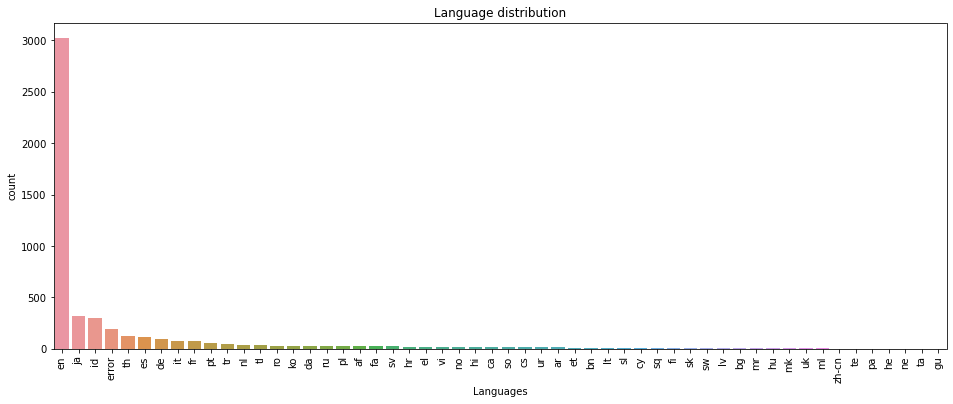

In [11]:
plt.figure(figsize=(16,6))


ax= sns.countplot(x= 'det_lang', data=df_updated, order = df_updated['det_lang'].value_counts(ascending=False).index)
ax.set_title('Language distribution')
ax.set_xlabel('Languages')

#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#plt.xticks(rotation=90) #outputs array before the graph

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    
plt.savefig('static/images/lan_dist.png',bbox_inches='tight')

In [12]:

#Ipython.OutputArea.auto_scroll_threshold = 10 #Tried to set the scroll display threshold. unsuccesful.

view_extracts=['description','det_lang','clean_captions','caption_processed_4','hashtags','cap_mentions','web_links' ]
#df_updated[view_extracts].loc[ex_row_list]

df_updated[view_extracts].head(100)

#add new elemnts to exemplar list
ex_row_list.append(3) #accents in differnt language





### Language
    - appears that errors in the language are for those descriptions which do not have readable text. Either blank or emojis. Fonts have been normalized but not much improvement.

In [13]:

df_updated[view3][df_updated['det_lang']=='error'].head(10)

,clean_captions,caption_processed,caption_processed_2,caption_processed_3,caption_processed_4,det_lang
2,,,,,,error
52,,,,,,error
53,•,•,•,,,error
56,❤🐔🐣🦆 . . . . .,❤🐔🐣🦆 . . . . .,❤🐔🐣🦆 . . . . .,❤🐔🐣🦆,❤🐔🐣🦆,error
61,💞 . . . .,💞 . . . .,💞 . . . .,💞,💞,error
64,,,,,,error
74,,,,,,error
126,,,,,,error
133,.,.,.,,,error
134,.,.,.,,,error


## Co-occurence matrix

Consider using a co-occurence matrix from the 3_Mar NLP notebook. In this matrix, it summarises the total extent of coccurence of any 2 unique words.
So each tweet (or caption text) is a matri with either '1' or '0'.

EAch iteration of the for loop (at lowest nested level), 1 unique word is tested for co-occurence with other words.

- for loop of tweets
    - for loop of 1st unique word in range of all unique
        - for loop of 1st vs {2nd, 3rd..nth word}
            - lowest level iteration adds a '1' or '0' to a list L1
        - At end of 1 full cycle of lowest level loop we have list of co-occ of first word with all other words L1:[1,0,0,1,..n]
    - At end of 2nd level loop, we have a co-occ matrix for a single tweet made of only 1's or 0's
    - [1st:[0,0,0,1,..n]  
         2nd:[1,0,1,1,..n]  
         nth:[0,1,1,0,..n]]  
         
         n*n matrix for each tweet.
         
- At the end of highest level loop (3rd level) sum of co-occ arrays of all tweets. So a single n*n matrix
           
        
        
          
           
           
           
           
           
         

## Use case of Co-occ matrixes:
### To make categories of types of businesses based on co-occuring hashtags
    - Get co-occurences by different categories. pharma, skincare, etc. Or causally interpret the categories based on the co-occurences. 
    - In this case, source the full list of co-occurences and just manually classify these into categories.
    
### Define a scale of business-likeness
    - A higher score may indicate more influence on things like(look for correlation):
        - choice of hashtags
        - frequency of posting 
        - co-occs with "trending" hashtags or terminology
        - count of hashtags
        - website :T or F
        - 
        
### Account for unrelated "#organic" posts
    - That is think about the usage where they just throw in the term to do some "virtue signalling".
    - If so what is the context of their signalling. exemplar index '80'. 
        - It is a vegan food item. But here maybe they are trying to signal "healthy" to eat? 
        
    
    
    
    

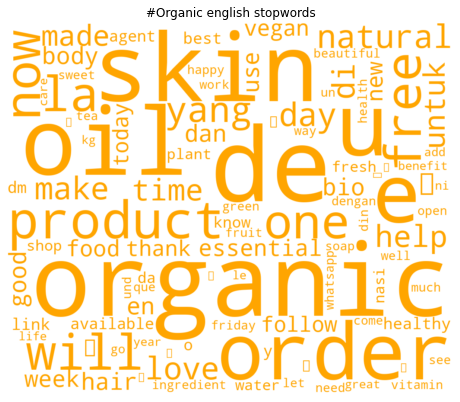

In [14]:
#Change the reference column for caption_processed.


word_string = ""
for ind,row in df_updated.iterrows():
    word_string += (row['caption_processed_4']+" ")

#size of plot
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)

wordcloud = WordCloud(max_words=100,    
                      stopwords= STOPWORDS,
                      collocations=False,
                      color_func=lambda *args, **kwargs: "orange",
                      background_color='white',
                      width=1200,     
                      height=1000).generate(word_string)
plt.title("#Organic english stopwords")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file("static/images/eng_sw_wc.png")

In [15]:
#Check example cases of the top words
# "ude", "la", "e", 


In [16]:
# Define stop words. Observed that french stop words may also need to be removed
#Add custom stopwords to the default "STOPWORDS" list


type(STOPWORDS) #set
len(STOPWORDS) #192

#stop_words = set(stopwords.words("english"))
#len(stop_words)#179

stop_words_fr= set(stopwords.words("french"))
len(stop_words_fr) #157

combined_stopwords=STOPWORDS.union(stop_words_fr)


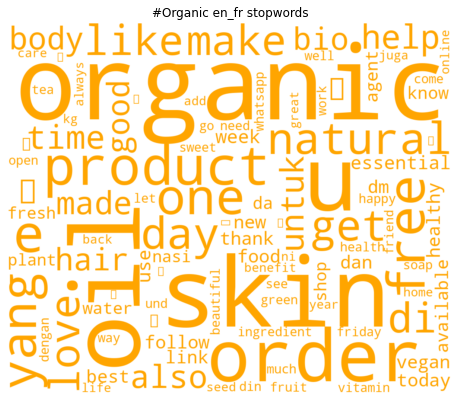

In [17]:

word_string = ""
for ind,row in df_updated.iterrows():
    word_string += (row['caption_processed_4']+" ")

    
    
#size of plot
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)

combined_stopwords = stopwords.words('english') + stopwords.words('french')

wordcloud = WordCloud(max_words=100,    
                      stopwords= combined_stopwords,
                      collocations=False,
                      color_func=lambda *args, **kwargs: "orange",
                      background_color='white',
                      width=1200,     
                      height=1000).generate(word_string)
plt.title("#Organic en_fr stopwords")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file("static/images/en_fr_sw_wc.png")

In [18]:
#check where the string has 'u', 'e', 'o'



    Punctutations removed and hence ('s ) used for plurals appears to dominate the wordcloud

    Construct the dahsboard as you move along. It is useful to use a dashboard view to compare charts and build a story as you move through it.

## Build a dashboard for the live view

    Have the graph objects in program buffer.
    Have a template which accepts the name of the graph objects. So just pass the graph objects into the template and render it.
    
    Use plotly dash. All these apps work well with a standalone .py file as obtained from a spyder env.

#### Notes about plotly wiht dash from the example code: https://www.youtube.com/watch?v=lVYRhHREkGo
    - First the layout is defined. A parent Div feeds its value to the child Divs. So the dropdown value updates both graphs.
    - Then for each graph, it has its own "callback" function. This has the input and output components defined, and an associated function which accepts the input and returns the output. The component property which is mentioned in the callback specifies the action type which trigger the value to be passed to the relevant graph.

In [19]:
df_updated[view_extracts].head(2)

,description,det_lang,clean_captions,caption_processed_4,hashtags,cap_mentions,web_links
2,#l4l #f4f #likeforlike #instalikesandfollowers4u #nature #instagood #organic #fff #love #vegandiet #nutricious #followforfollow #photooftheday #lfl #like4like #instalike #vegetables #instafood #healthyfood #follow4follow #food #instadaily @rocket_hastags #healthy #foodpics #veganlife,error,,,#l4l #f4f #likeforlike #instalikesandfollowers4u #nature #instagood #organic #fff #love #vegandiet #nutricious #followforfollow #photooftheday #lfl #like4like #instalike #vegetables #instafood #healthyfood #follow4follow #food #instadaily #healthy #foodpics #veganlife,@rocket_hastags,
3,Originál je pouze jeden! Posílame každý den kurýrem přímo k vám..📬 Děkujeme za krásné foto..❤️ https://carboncoco.cz/ ⚫️👉🏽😁👉🏽💎 @carboncoco_cz #přírodní #bělení #zubů #krásnej #zdravej #bílej #úsměv #bezbolesti #bezchemie #naturalbeauty #organic #whiteteeth #veganfriendly #nottestedonanimals #🐾❤,cs,Originál je pouze jeden! Posílame každý den kurýrem přímo k vám..📬 Děkujeme za krásné foto..❤️ ⚫️👉🏽😁👉🏽💎,originál je pouze jeden posílame každý den kurýrem přímo k vám 📬 děkujeme za krásné foto ❤️ ⚫️👉🏽😁👉🏽💎,#přírodní #bělení #zubů #krásnej #zdravej #bílej #úsměv #bezbolesti #bezchemie #naturalbeauty #organic #whiteteeth #veganfriendly #nottestedonanimals #🐾❤,@carboncoco_cz,https://carboncoco.cz/


### Dash table display

In [ ]:
import pandas as pd     #(version 1.0.0)
import plotly           #(version 4.5.4) pip install plotly==4.5.4
import plotly.express as px

import dash             #(version 1.9.1) pip install dash==1.9.1
import dash_table
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

app = dash.Dash(__name__)

#---------------------------------------------------------------

dff=df_updated[view_extracts]
#print (dff[:5])
#---------------------------------------------------------------
app.layout = html.Div([
    html.Div([
        dash_table.DataTable(
            id='datatable_id',
            data=dff.to_dict('rows'),
            columns=[
                {"name": i, "id": i, "deletable": False, "selectable": False} for i in dff.columns
            ],
            editable=False,
            filter_action="native",
            sort_action="native",
            sort_mode="multi",
            row_selectable="multi",
            row_deletable=False,
            selected_rows=[],
            page_action="native",
#             page_current= 0,
#             page_size= 6,
            # page_action='none',
            
            css=[{'selector': 'table', 'rule': 'table-layout: fixed'}], #this seems to do the trick for the column resizing. But works only with px setting and not %
#             
            
            fixed_rows={ 'headers': True, 'data': 0 },
            virtualization=False,
            style_cell_conditional=[
                {'if': {'column_id': 'description'},
                 'width': '350px', 'textAlign': 'left'}, #Setting the px values 1400px seems to cover the width of the screen. 
                
                {'if': {'column_id': 'det_lang'},
                 'width': '50px', 'textAlign': 'left'},
                
                {'if': {'column_id': 'clean_captions'},
                 'width': '350px', 'textAlign': 'left'},
                
                {'if': {'column_id': 'caption_processed_4'},
                 'width': '100px', 'textAlign': 'left'},
                
                {'if': {'column_id': 'hashtags'},
                 'width': '350px', 'textAlign': 'left'},
                
                {'if': {'column_id': 'cap_mentions'},
                 'width': '100px', 'textAlign': 'left'},
                
#                 {'if': {'column_id': 'web_links'}, #when the last column is set, the table breaks. find way to define table max_width 
#                  'width': '10px', 'textAlign': 'left'},
            ],
#             style_table={
#                 #'minWidth': '100%'
#                 'overflowX': 'auto'
#             }
            style_table={
                'maxHeight': '50ex',
                'overflowY': 'auto',
                'width': '100%',
                'maxWidth': '100%',
                },
        ),
    ],className='row'),



])

if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

INFO:__main__:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
INFO:werkzeug: * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [27/Aug/2021 17:03:16] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Aug/2021 17:03:16] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2021 17:03:17] "GET /_dash-dependencies HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Aug/2021 17:03:17] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2021 17:03:17] "GET /_dash-layout HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Aug/2021 17:03:17] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2021 17:03:18] "GET /_dash-component-suites/dash_table/async-highlight.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Aug/2021 17:03:18] "GET /_dash-component-suites/dash_table/async-highlight.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2021 17:03:18] "GET /_dash-component-suites/dash_table/async-table.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Aug/2021 17:03:18] "GET /_